In [1]:
import time

import numpy as np
import tensorflow as tf

import re
from collections import Counter
from time import sleep
import json

import random

In [2]:
with open('ner_test.json') as json_data:
    d = json.load(json_data)

text=[]
l=0

for i in d:
    for j in i:
        for k in j:
            text.append(k)

tt = []
for i in range(len(text)):
    if(text[i]!=''):
        tt.append(text[i])

text = tt

word_counts = Counter(text)

word_counts.most_common()

[('O', 275616), ('ORGANIZATION', 8190), ('PERSON', 7738), ('LOCATION', 7501)]

In [3]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)


def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [4]:
words = text

print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

# vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Your code here
from collections import Counter
import random

threshold = 1e-1
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

word_counts = Counter(train_words)

word_counts.most_common()

Total words: 299045
Unique words: 4


[(0, 90810), (1, 8190), (2, 7738), (3, 7501)]

In [5]:
batch_size = 1000
window_size = 2
n_vocab = len(int_to_vocab)
n_embedding =  25

In [12]:
with tf.device('/device:GPU:1'):

    train_graph = tf.Graph()
    with train_graph.as_default():
        inputs = tf.placeholder(tf.int32, [None], name='inputs')
    #     labels = tf.placeholder(tf.int32, [None, None], name='labels')
        labels = tf.placeholder(tf.int32, [None, None], name='labels')
        
        embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
        embed = tf.nn.embedding_lookup(embedding, inputs) # use tf.nn.embedding_lookup to get the hidden layer output
        
        softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding))) # create softmax weight matrix here
        softmax_b = tf.Variable(tf.zeros(n_vocab), name="softmax_bias") # create softmax biases here
        
        logits = tf.matmul(embed, tf.transpose(softmax_w)) + softmax_b
        labels_one_hot = tf.one_hot(labels, n_vocab)

        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels_one_hot, logits=logits)
        cost = tf.reduce_mean(loss)
        
        global_step = tf.Variable(0, trainable=False, name="global_step")

        optimizer = tf.train.AdamOptimizer().minimize(cost, global_step=global_step)
        
         ## From Thushan Ganegedara's implementation
        valid_size = 3 # Random set of words to evaluate similarity on.
        valid_window = n_vocab
        # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
        valid_examples = np.array(random.sample(range(valid_window), valid_size))
#         valid_examples = np.append(valid_examples, 
#                                    random.sample(range(1000,1000+valid_window), valid_size//2))

        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
        normalized_embedding = embedding / norm
        valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
        similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [13]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints/ner

mkdir: cannot create directory ‘checkpoints/ner’: File exists


In [18]:
epochs = 100

In [19]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())
    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/ner'))
    embed_mat = sess.run(embedding)
    
    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            global_steps, train_loss, _ = sess.run([global_step, cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100== 0: 
                end = time.time()
                print("Global Step: {}".format(global_steps), "Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
                        
            iteration += 1
    save_path = saver.save(sess, "checkpoints/ner/ner.ckpt")
    embed_mat = sess.run(normalized_embedding)

INFO:tensorflow:Restoring parameters from checkpoints/ner/ner.ckpt
Global Step: 5800 Epoch 1/100 Iteration: 100 Avg. Training loss: 0.8470 0.0131 sec/batch
Global Step: 5900 Epoch 2/100 Iteration: 200 Avg. Training loss: 0.8536 0.0111 sec/batch
Global Step: 6000 Epoch 3/100 Iteration: 300 Avg. Training loss: 0.8483 0.0094 sec/batch
Global Step: 6100 Epoch 4/100 Iteration: 400 Avg. Training loss: 0.8519 0.0074 sec/batch
Global Step: 6200 Epoch 5/100 Iteration: 500 Avg. Training loss: 0.8387 0.0053 sec/batch
Global Step: 6300 Epoch 6/100 Iteration: 600 Avg. Training loss: 0.8556 0.0050 sec/batch
Global Step: 6400 Epoch 7/100 Iteration: 700 Avg. Training loss: 0.8463 0.0022 sec/batch
Global Step: 6500 Epoch 8/100 Iteration: 800 Avg. Training loss: 0.8399 0.0004 sec/batch
Global Step: 6600 Epoch 8/100 Iteration: 900 Avg. Training loss: 0.8446 0.0149 sec/batch
Global Step: 6700 Epoch 9/100 Iteration: 1000 Avg. Training loss: 0.8555 0.0120 sec/batch
Global Step: 6800 Epoch 10/100 Iteration: 

Global Step: 14700 Epoch 79/100 Iteration: 9000 Avg. Training loss: 0.8348 0.0144 sec/batch
Global Step: 14800 Epoch 80/100 Iteration: 9100 Avg. Training loss: 0.8545 0.0137 sec/batch
Global Step: 14900 Epoch 81/100 Iteration: 9200 Avg. Training loss: 0.8406 0.0110 sec/batch
Global Step: 15000 Epoch 82/100 Iteration: 9300 Avg. Training loss: 0.8697 0.0096 sec/batch
Global Step: 15100 Epoch 83/100 Iteration: 9400 Avg. Training loss: 0.8263 0.0081 sec/batch
Global Step: 15200 Epoch 84/100 Iteration: 9500 Avg. Training loss: 0.8509 0.0053 sec/batch
Global Step: 15300 Epoch 85/100 Iteration: 9600 Avg. Training loss: 0.8525 0.0036 sec/batch
Global Step: 15400 Epoch 86/100 Iteration: 9700 Avg. Training loss: 0.8512 0.0015 sec/batch
Global Step: 15500 Epoch 86/100 Iteration: 9800 Avg. Training loss: 0.8307 0.0138 sec/batch
Global Step: 15600 Epoch 87/100 Iteration: 9900 Avg. Training loss: 0.8433 0.0137 sec/batch
Global Step: 15700 Epoch 88/100 Iteration: 10000 Avg. Training loss: 0.8494 0.01

In [352]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/ner'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


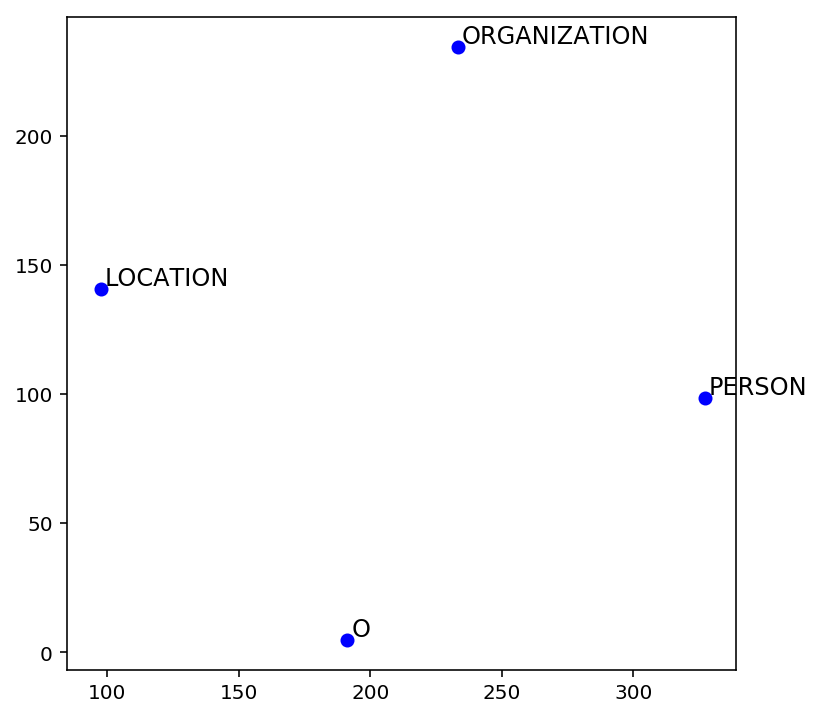

In [42]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = n_vocab
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(6, 6))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='blue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=1, xytext=(embed_tsne[idx, 0]+1.5, embed_tsne[idx, 1]+1.5), fontsize=12)